# Implementación de Redes Neuronales 

El presente cuaderno tiene como finalidad los siguientes objetivos:

- Profundizar el entendimiento del algoritmo de *Back-propagation* para el entrenamiento de Redes Neuronales densas.
- Explorar los mecanismos para evitar el *Overfitting* del algoritmo mediante los métodos **L2**, **L1** y **Dropout**.

## El algoritmo de *Back propagation*

El primer paso es importar las librerías que necesitamos:

In [1]:
from numpy import array, zeros, exp, random, dot, shape, reshape, meshgrid, linspace, transpose

import matplotlib.pyplot as plt # for plotting
import matplotlib
matplotlib.rcParams['figure.dpi'] = 300 # High resolution display

El siguiente paso sería el de obtener las funciones preliminares necesarias para poder implementar el algoritmo:

La función de activación es la función sigmoide:
$$y=f(z)$$
$$y=\frac{1}{1+e^{-z}}$$

De donde tenemos que:
$$y'=\frac{e^{-z}}{(1+e^{-z})^{2}}$$

O, escrito de otra forma:
$$y'=\frac{df}{dz}$$

$$y'=e^{-z}\left(\frac{1}{1+e^{-z}}\right)^{2}$$

O, también 
$$y'=e^{-z}\left[f(z)\right]^{2}$$

$$y'=y(1-y)$$

In [2]:
def net_f_df(z): # Calcula la función de activación f(z) y su derivada f'(z)
    val = 1 / (1 + exp(-z)) # sigmoid
    return ( val, exp(-z)*(val ** 2) )

La siguiente función calcula los valores $y$ de la capa posterior y retorna los valores de $f$ y $f'$ correspondientes. El objetivo es guardarlos para utilizarlos después en el algoritmo. 

In [3]:
def forward_step(y, w, b):
    """
    Calcula los valores de la siguiente capa (layer) dados:
        y: Vector de la capa anterior a la capa que se va a calacular.
        w: Matriz de pesos (weights) utilizados que conectan las dos capas.
        b: vector de sesgos (bias)
    """
    z = dot(y, w) + b
    return (net_f_df(z)) # Aplica la no-linealidad y retorna el resultado.

El algoritmo de *Back-propagation* afirma que:

$$\frac{\partial E}{\partial y_{i}}=\sum_{j}w_{ij}y_{j}\left(1-y_{j}\right)\frac{\partial E}{\partial y_{j}}$$

Mientras que la actualización de los valores de los pesos, determinado por el algoritmo de *Gradient Descent* sigue la regla:

$$\Delta w_{ij} = -\sum_{k\in\text{dataset}}\alpha y_{i}^{(k)}y_{j}^{(k)}\left(1-y_{j}^{(k)}\right)\frac{\partial E^{(k)}}{\partial y_{j}^{(k)}}$$





La siguiente función calcula y almacena $y$ y $f'(z)$ para toda la red.

In [4]:
def apply_net(y_in):
    """
    Realiza un cálculo en toda la red neuronal con un ejemplo de entrenamiento y_in
    """
    global Weights, Biases, NumLayers 
    global y_layer, df_layer # para almacenar y-valores y df/dz-valores
    
    y = y_in # Empezamos con los valores de entrada
    y_layer[0] = y
    
    for j in range(NumLayers): # loop en el número de capas
        # j = 0 corresponde a la primera capa por encima de la capa de entrada
        y, df = forward_step(y, Weights[j], Biases[j]) # Un paso
        df_layer[j] = df # Almacena f'(z) [utilizado posteriormente en el algoritmo de Back propagation]
        y_layer[j+1] = y # Almacena y = f(z) [también utilizado en el algoritmo]
    return (y)

In [5]:
def apply_net_simple(y_in):
    """
    Un paso completo a través de la red completa. Sin almacenamiento para el back-propagation (Utilizado para pruebas)
    """
    y = y_in # Empezar con los valores de entrada
    y_layer[0] = y
    for j in range(NumLayers): # loop a través de todas las capas de la red
        # j = 0 corresponde con la primera capa por encima de la capa de entrada
        y, df = forward_step(y, Weights[j], Biases[j]) # un paso
    return (y)  

El algoritmo de *Back-propagation* debe su nombre debido al cálculo de las derivadas de la función de costos (o de error $E$) con respecto a los valores de las neuronas en cada capa. De ésta manera, para calcular el valor de dicha derivada en la capa $i-$ésima (inferior), requerimos saber de todas las derivadas de la función de error con respecto a la capa $j-$ésima (inferior). En general, tenemos que:

$$\frac{\partial E}{\partial y_{i}}=\sum_{j}w_{ij}\underbrace{\left[y_{j}\left(1-y_{j}\right)\right]}_{=f'(z_{j})}\cdot\frac{\partial E}{\partial y_{j}}$$

Denotaremos $$\Delta_{j}=\frac{\partial E}{\partial y_{j}}$$.

De ésta manera, la siguiente función nos permite calcular $$(\boldsymbol{\Delta}\otimes f'(\mathbf{z})\cdot W^{T})$$

In [6]:
def backward_step(delta, w, df):
    """
    delta en la capa N, de batchsize x layersize(N)
    w entre N-1 y N [layersize(N-1) x layersize(N) matrix]
    df = df/dz en la capa N-1, de batchsize x layersize(N-1)
    """
    return ( dot(delta * df, transpose(w)) )

Formalmente, el cambio para los pesos viene determinado por:

$$\Delta w_{ij} = -\eta\sum_{k\in\text{dataset}}y_{i}^{(k)}y_{j}^{(k)}\left(1-y_{j}^{(k)}\right)\frac{\partial E^{(k)}}{\partial y_{j}^{(k)}}$$

En donde podemos asociar:

$$y_{i}^{(k)}\rightarrow\text{Capa anterior}$$

$$y_{j}^{(k)}\left(1-y_{j}^{(k)}\right)\rightarrow f'(z_{j}^{(k)})\text{ (Capa actual)}$$


In [7]:
def backprop(y_target): 
    """
    Un paso anterior a través de la red.
    El resultado serán las matrices 'dw_layer' que
    contienen las derivadas de la función de costo con respecto al
    peso correspondiente
    """
    global y_layer, df_layer, Weights, Biases, NumLayers
    global dw_layer, db_layer # dCost/dw y dCost/db ( w, b = weights, biases)
    global batchsize
    
    delta = (y_layer[-1] - y_target)  # Ésta es la derivada de la función de costo con respecto a 
    # la salida de la última capa. El producto '*' ocurre componente a componente
    dw_layer[-1] = dot(transpose(y_layer[-2]), delta * df_layer[-1])/batchsize 
    db_layer[-1] = (delta * df_layer[-1]).sum(0) / batchsize
    for j in range(NumLayers - 1):
        delta = backward_step(delta, Weights[-1-j], df_layer[-1-j])
        dw_layer[-2-j] = dot(transpose(y_layer[-3-j]), delta * df_layer[-2-j])
        db_layer[-2-j] = (delta * df_layer[-2-j]).sum(0)/batchsize

In [8]:
def gradient_step(eta): 
    """
    Actualización de pesos y sesgos (después del algoritmo de Back-Propagation!)
    """
    global dw_layer, db_layer, Weights, Biases
    
    for j in range(NumLayers):
        Weights[j] -= eta * dw_layer[j]
        Biases[j] -= eta * db_layer[j]

In [9]:
def train_net(y_in, y_target, eta):
    """
    un batch de entrenamiento completo
    y_in: es un arreglo de tamaño batchsize x (input - layer - size)
    y_target es un arreglo de tamaño batchsize x (output - layer - size)
    eta es el tamaño del paso del gradiente descendiente
    """
    global y_out_result
    
    y_out_result = apply_net(y_in)
    backprop(y_target)
    gradient_step(eta)
    cost = ((y_target - y_out_result) ** 2).sum()/batchsize
    return (cost)

## Configuración de un conjunto particular de tamaños de capas.

In [10]:
# Configuración de todos los pesos y sesgos

NumLayers = 3 # No cuenta la capa de entrada (pero cuenta la capa de salida)
LayerSizes = [2, 20, 30, 1] # capa de entrada, oculta-1, oculta-2, ..., capa de salida

#Inicie pesos y sesgos aleatorios para todas las capas (a excepción de la capa de entrada)
Weights = [random.uniform(low = -1, high = +1, size = [ LayerSizes[j], LayerSizes[j + 1]]) for j in range(NumLayers)]
Biases = [random.uniform(low = -1, high = +1, size = LayerSizes[j+1]) for j in range(NumLayers)]

# definir el batchsize
batchsize = 100

In [11]:
# Configurar todas las variables auxiliares

y_layer = [zeros([batchsize, LayerSizes[j]]) for j in range(NumLayers + 1)]
df_layer = [zeros([batchsize, LayerSizes[j+1]]) for j in range(NumLayers)]
dw_layer = [zeros([LayerSizes[j], LayerSizes[j+1]]) for j in range(NumLayers)]
db_layer = [zeros(LayerSizes[j+1]) for j in range(NumLayers)]

## Entrenar la red en un sólo batch repetidamente (No tan bueno)

In [12]:
y_in = random.uniform(low = -1, high = +1, size = [batchsize, LayerSizes[0]])
y_target = random.uniform(low = -1, high = +1, size = [batchsize, LayerSizes[-1]])

In [13]:
train_net(y_in, y_target, 0.0001) # Retorna el valor de la función de costos

1.1335633880307758

In [14]:
eta = 0.001
batches = 200

costs = zeros(batches) # arreglo para almacenar los costos

for k in range(batches):
    costs[k] = train_net(y_in, y_target, eta)    

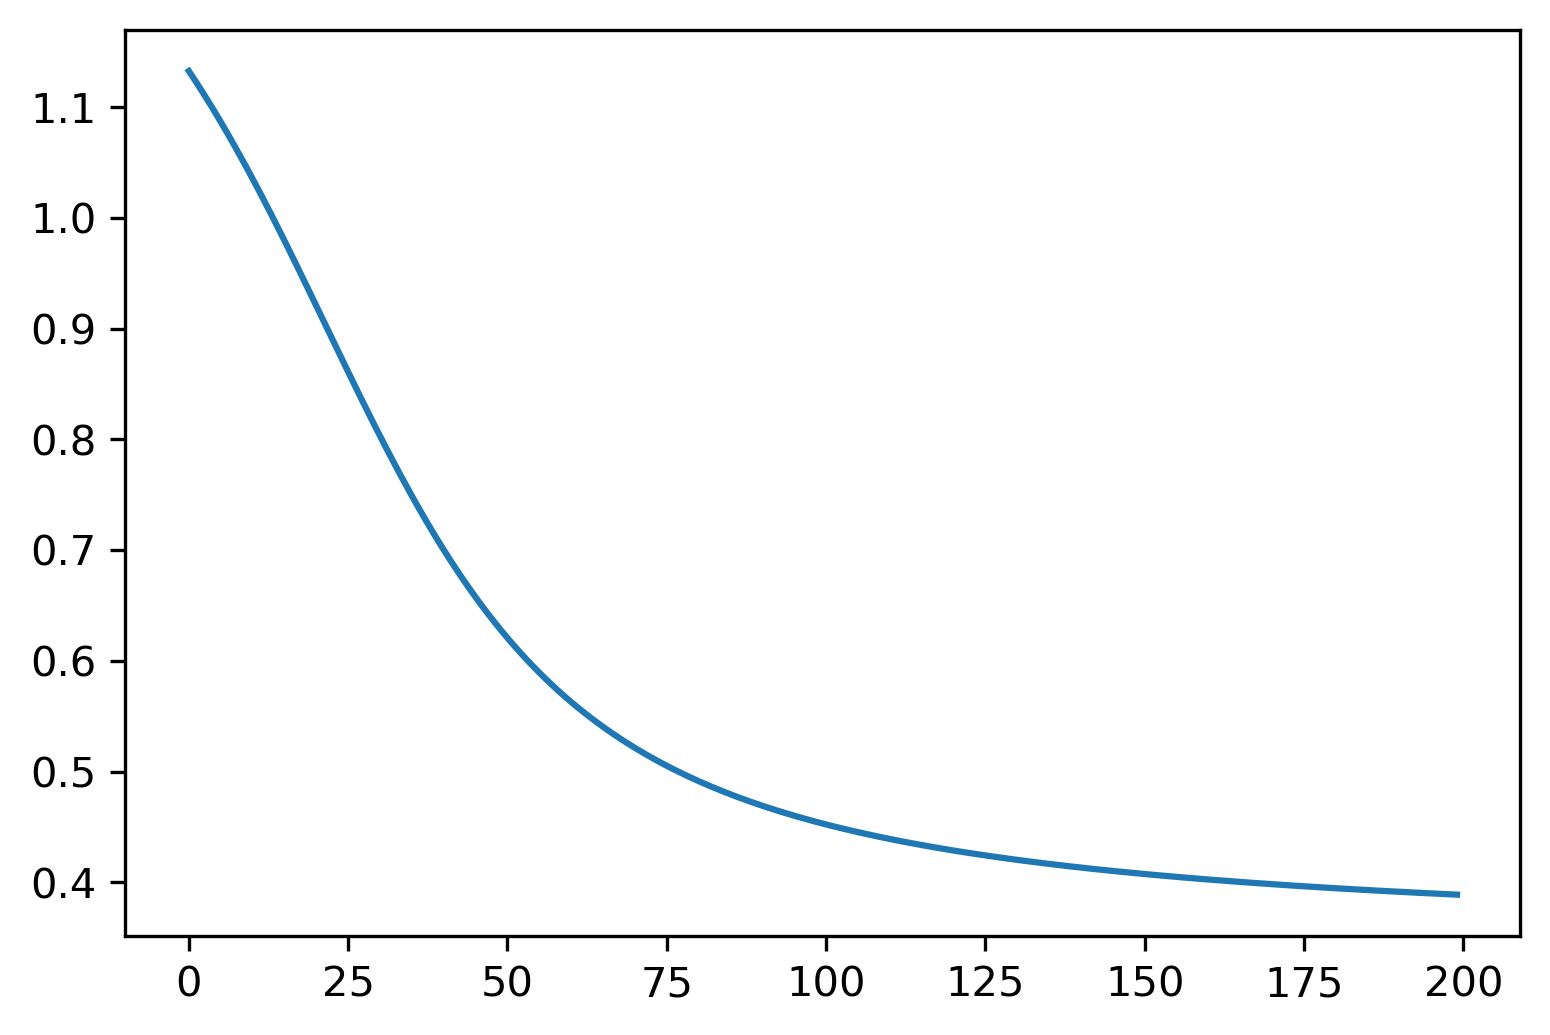

In [15]:
"""
Esto mostrará un decrecimiento simple, ya que
no estamos aleatoriamente muestreando entradas
(es siempre la misma entrada!) así que la red
solamente es buena para esa entrada
"""
plt.plot(costs)
plt.show()

In [16]:
# For a change: Set up rectified linear units (relu) 
# instead of sigmoid
def net_f_df(z): # calculate f(z) and f'(z)
    val=z*(z>0)
    return(val,z>0) # return both f and f'

In [17]:
# set up all the weights and biases

NumLayers=2 # does not count input-layer (but does count output)
LayerSizes=[2, 100, 1] # input-layer,hidden-1,hidden-2,...,output-layer

Weights=[random.uniform(low=-0.1,high=+0.1,size=[ LayerSizes[j],LayerSizes[j+1] ]) for j in range(NumLayers)]
Biases=[zeros(LayerSizes[j+1]) for j in range(NumLayers)]

# set up all the helper variables

y_layer=[zeros(LayerSizes[j]) for j in range(NumLayers+1)]
df_layer=[zeros(LayerSizes[j+1]) for j in range(NumLayers)]
dw_layer=[zeros([LayerSizes[j],LayerSizes[j+1]]) for j in range(NumLayers)]
db_layer=[zeros(LayerSizes[j+1]) for j in range(NumLayers)]

In [18]:
# define the batchsize
batchsize=100

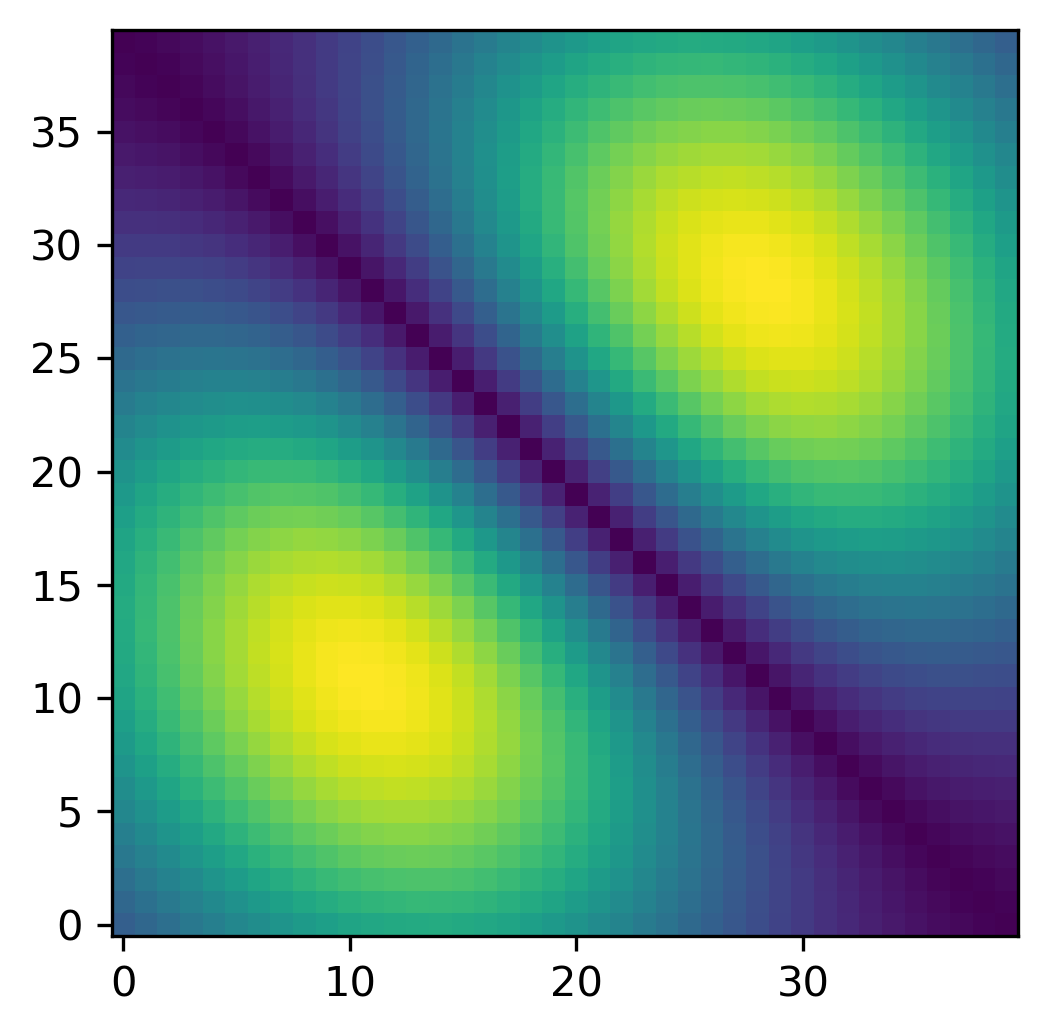

In [19]:
def myFunc(x0,x1):
    r2=x0**2+x1**2
    return(exp(-5*r2)*abs(x1+x0))

xrange=linspace(-0.5,0.5,40)
X0,X1=meshgrid(xrange,xrange)
plt.imshow(myFunc(X0,X1),interpolation='nearest',origin='lower')
plt.show()

In [20]:
def make_batch():
    global batchsize

    inputs=random.uniform(low=-0.5,high=+0.5,size=[batchsize,2])
    targets=zeros([batchsize,1]) # must have right dimensions
    targets[:,0]=myFunc(inputs[:,0],inputs[:,1])
    return(inputs,targets)

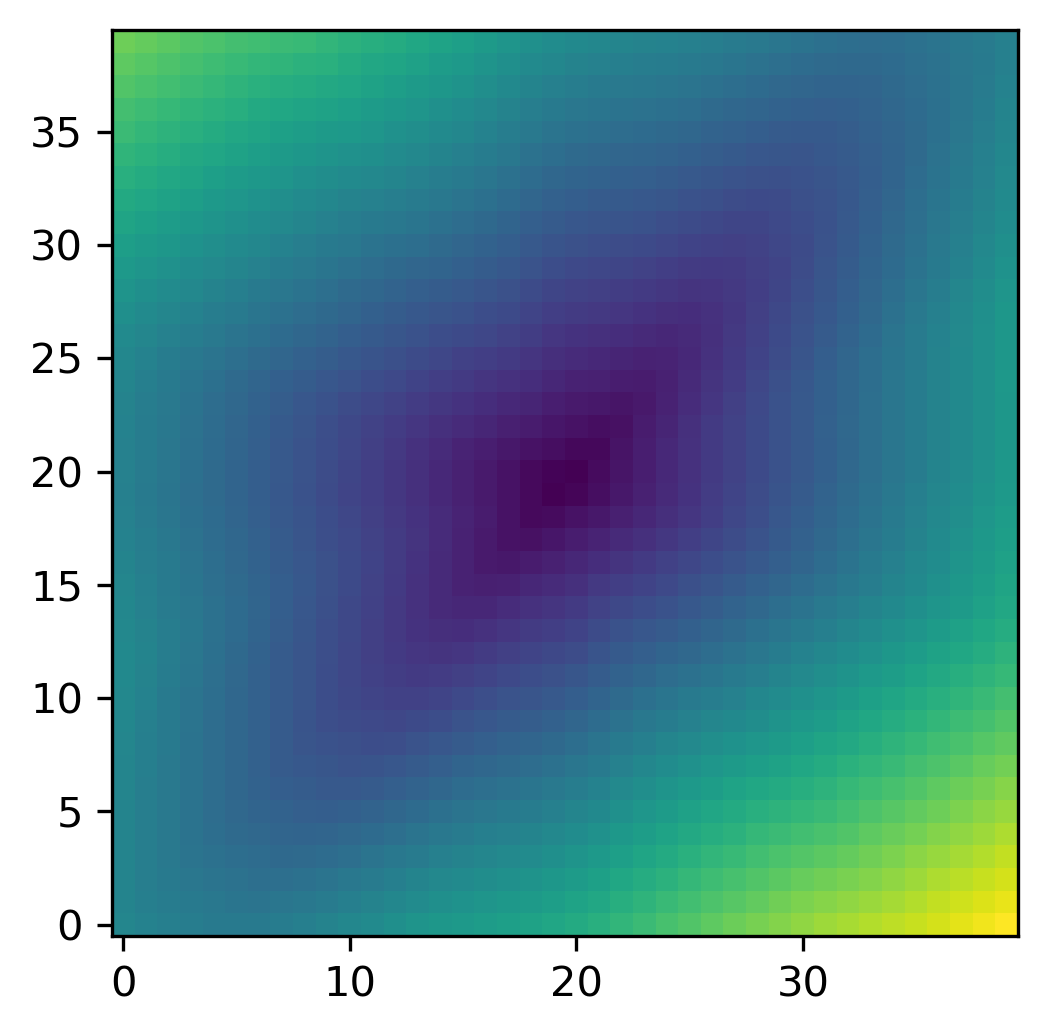

In [21]:
# try to evaluate the (randomly initialized) network
# on some area in the 2D plane
test_batchsize=shape(X0)[0]*shape(X0)[1]
testsample=zeros([test_batchsize,2])
testsample[:,0]=X0.flatten()
testsample[:,1]=X1.flatten()

testoutput=apply_net_simple(testsample)
myim=plt.imshow(reshape(testoutput,shape(X0)),origin='lower',interpolation='none')
plt.show()

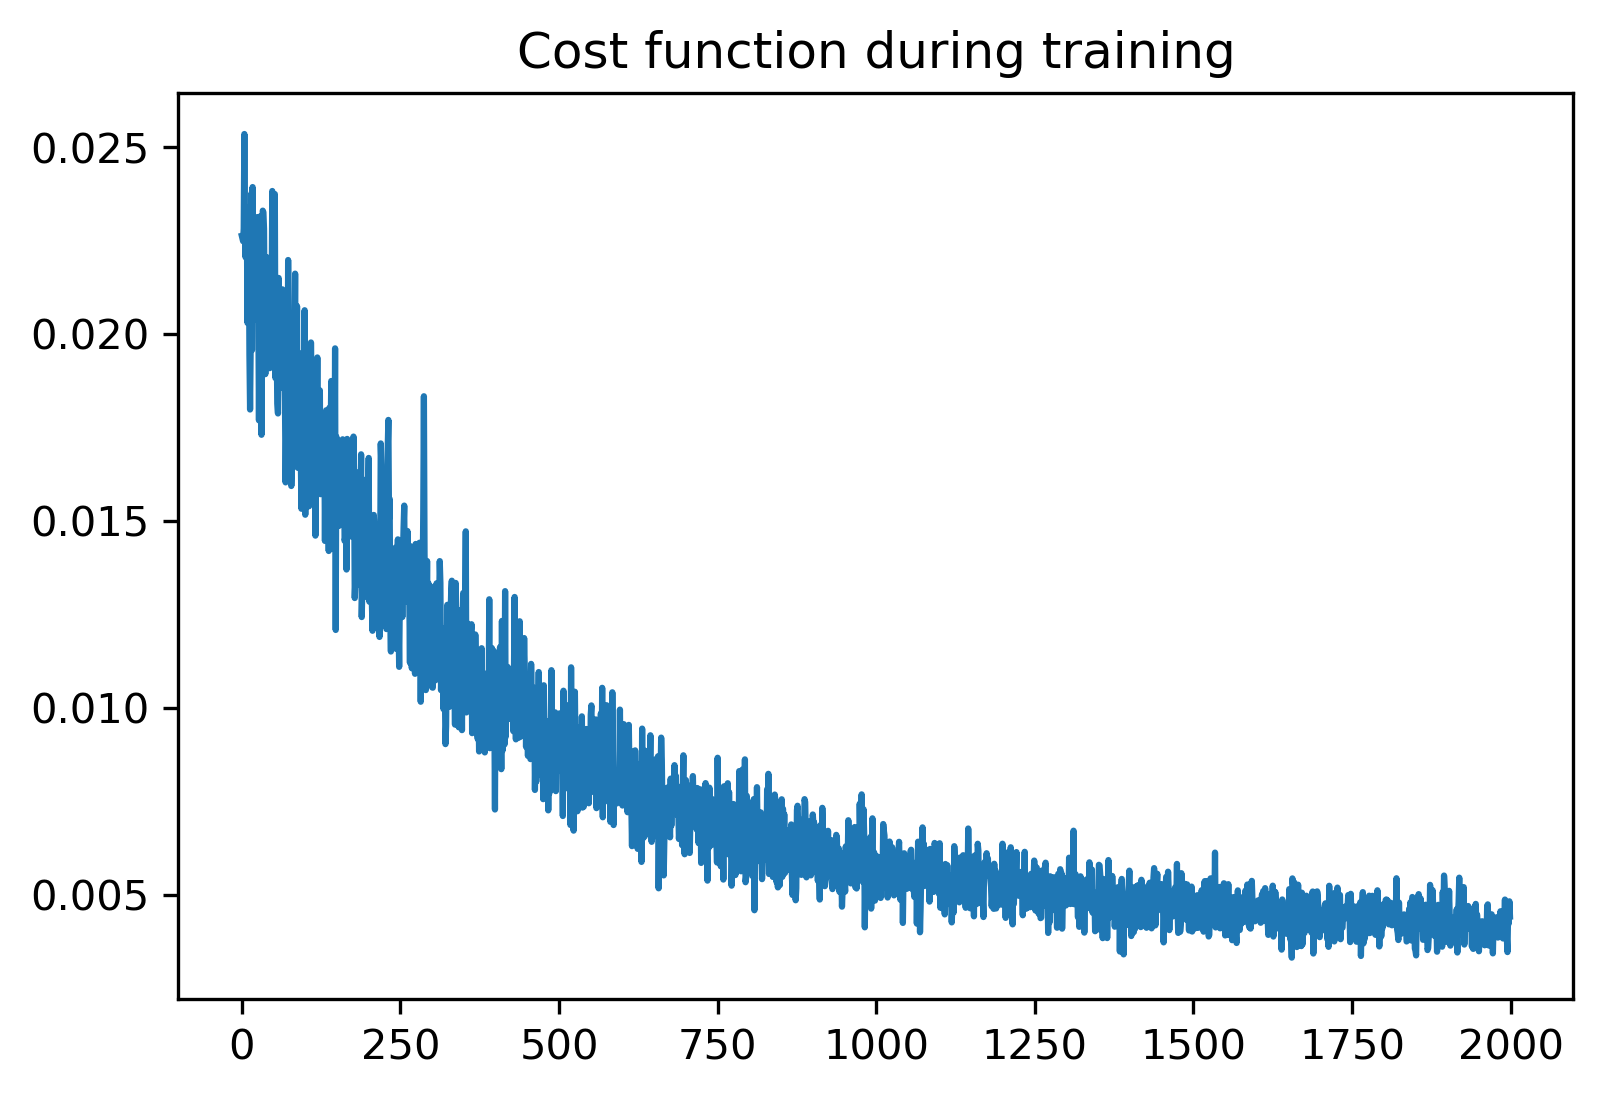

In [22]:
# now train on randomly sampled points
# to make the network reproduce better and
# better this 2D function!
eta=.001
batches = 2000
costs=zeros(batches)

for k in range(batches):
    y_in,y_target=make_batch()
    costs[k]=train_net(y_in,y_target,eta)

plt.plot(costs)
plt.title("Cost function during training")
plt.show()


In [23]:
# start fresh:

# set up all the weights and biases

NumLayers=2 # does not count input-layer (but does count output)
LayerSizes=[2,100,1] # input-layer,hidden-1,hidden-2,...,output-layer

Weights=[random.uniform(low=-0.1,high=+0.1,size=[ LayerSizes[j],LayerSizes[j+1] ]) for j in range(NumLayers)]
Biases=[zeros(LayerSizes[j+1]) for j in range(NumLayers)]

# set up all the helper variables

y_layer=[zeros(LayerSizes[j]) for j in range(NumLayers+1)]
df_layer=[zeros(LayerSizes[j+1]) for j in range(NumLayers)]
dw_layer=[zeros([LayerSizes[j],LayerSizes[j+1]]) for j in range(NumLayers)]
db_layer=[zeros(LayerSizes[j+1]) for j in range(NumLayers)]

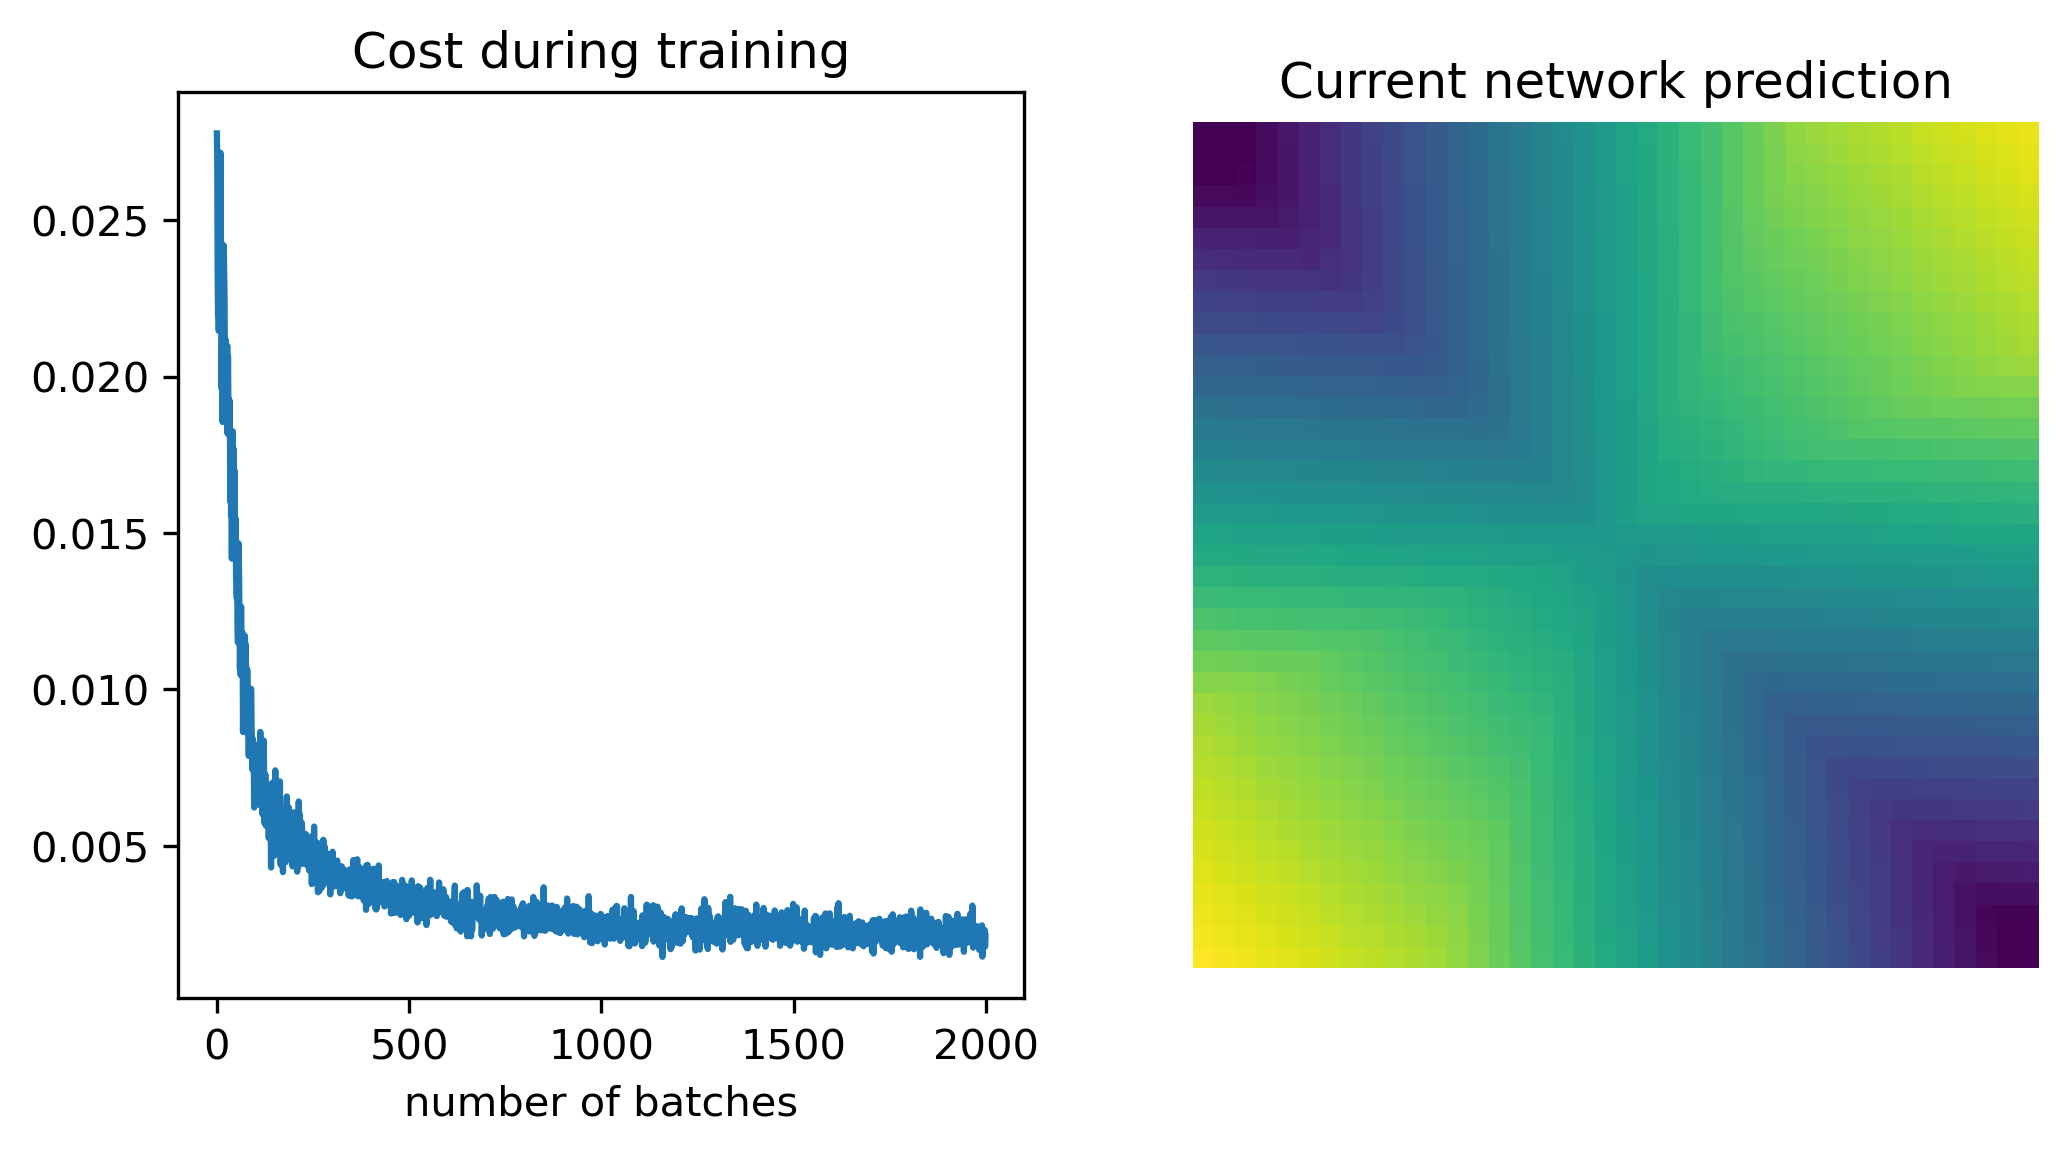

In [24]:
# import functions for updating display 
# (simple animation)
from IPython.display import clear_output
from time import sleep

eta=0.01 # learning rate
nsteps=2000

costs=zeros(nsteps)
for j in range(nsteps):
    clear_output(wait=True)
    fig,ax=plt.subplots(ncols=2,nrows=1,figsize=(8,4)) # prepare figure
    ax[1].axis('off') # no axes
    
    # the crucial lines:
    y_in,y_target=make_batch() # random samples (points in 2D)
    costs[j]=train_net(y_in,y_target,eta) # train network (one step, on this batch)
    testoutput=apply_net_simple(testsample) # check the new network output in the plane
    
    img=ax[1].imshow(reshape(testoutput,shape(X0)),interpolation='nearest',origin='lower') # plot image
    ax[0].plot(costs)
    
    ax[0].set_title("Cost during training")
    ax[0].set_xlabel("number of batches")
    ax[1].set_title("Current network prediction")
    plt.show()
    sleep(0.1)

In [25]:
costs[-1]

0.0021081779415609053